In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [2]:
#Load training and validation data
train_df = pd.read_csv('SH_pixels_training_data.csv')
valid_df = pd.read_csv('SH_pixels_validation_data.csv')

#Remove 'system:index' column and extract features and labels
def prepare_data(df):
    df = df.drop(columns=['system:index'], errors='ignore')
    
    # Specify the order of feature columns (must match CSV headers)
    ordered_features = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7',
                        'B8', 'B8A', 'B11', 'B12',
                        'NDVI', 'NDWI', 'NDBI', 'BSI']
    
    X = df[ordered_features]
    y = df['class']
    return X.values, y.values

X_train, y_train = prepare_data(train_df)
X_valid, y_valid = prepare_data(valid_df)


In [3]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (100, 50), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_grid = MLPClassifier(max_iter=500, early_stopping=True, n_iter_no_change=20, random_state=42)

# cv=3 means 3-fold cross-validation. n_jobs=-1 uses all available CPU cores.
grid_search = GridSearchCV(estimator=mlp_grid, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_mlp = grid_search.best_estimator_

print("Best Parameters Found: ", grid_search.best_params_)

y_pred = best_mlp.predict(X_valid_scaled)
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Classification Report:\n", classification_report(y_valid, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant; total time=   0.6s
[CV] END activat

In [4]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import numpy as np
import pandas as pd

cm = confusion_matrix(y_valid, y_pred)

PA = np.diag(cm) / np.sum(cm, axis=1)

UA = np.diag(cm) / np.sum(cm, axis=0)

kappa = cohen_kappa_score(y_valid, y_pred)

class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

print("=== Accuracy Metrics ===")
print(f"Overall Accuracy: {accuracy_score(y_valid, y_pred):.2f}")
print(f"Kappa Coefficient: {kappa:.2f}\n")

for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Producer's Accuracy (PA): {PA[i]:.2f}")
    print(f"  User's Accuracy (UA):     {UA[i]:.2f}")


=== Accuracy Metrics ===
Overall Accuracy: 0.98
Kappa Coefficient: 0.98

Water:
  Producer's Accuracy (PA): 1.00
  User's Accuracy (UA):     1.00
Trees:
  Producer's Accuracy (PA): 0.94
  User's Accuracy (UA):     0.98
Crops:
  Producer's Accuracy (PA): 0.98
  User's Accuracy (UA):     0.96
Built:
  Producer's Accuracy (PA): 0.99
  User's Accuracy (UA):     0.96
Bare:
  Producer's Accuracy (PA): 1.00
  User's Accuracy (UA):     0.99


In [5]:

acc_df = pd.DataFrame({
    'Class': class_names,
    'Producer Accuracy (PA)': PA,
    'User Accuracy (UA)': UA
})

print("\nPer-class Accuracy Summary:")
print(acc_df)



Per-class Accuracy Summary:
   Class  Producer Accuracy (PA)  User Accuracy (UA)
0  Water                1.000000            1.000000
1  Trees                0.937294            0.979310
2  Crops                0.975779            0.962457
3  Built                0.986063            0.962585
4   Bare                1.000000            0.993730


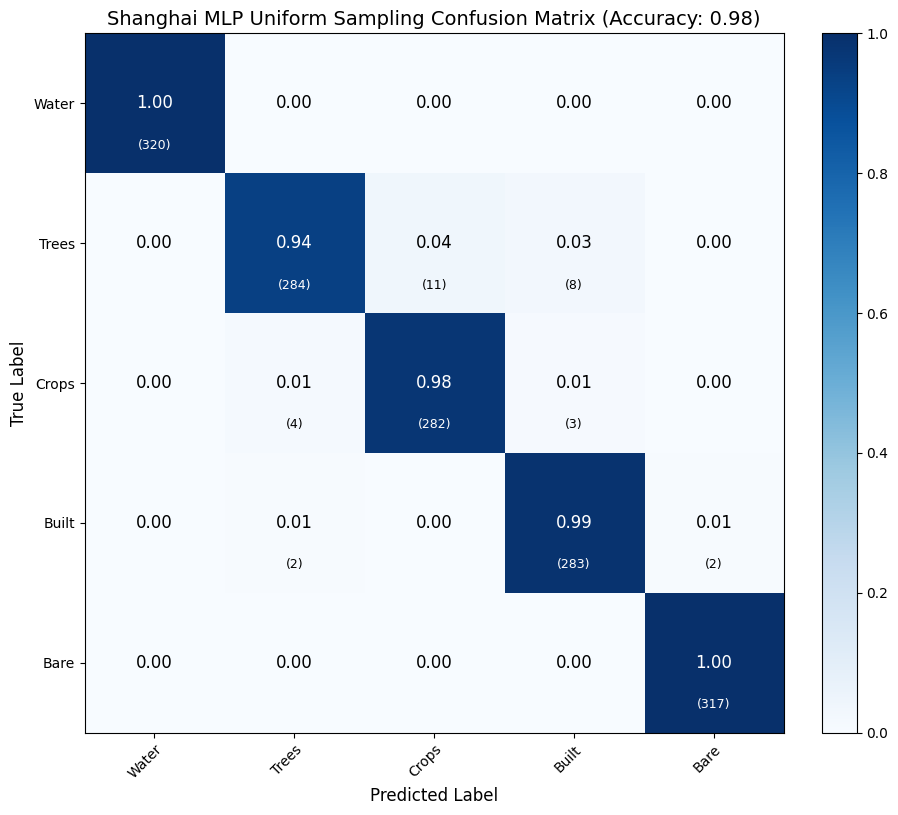

In [6]:
def plot_confusion_matrix_advanced(y_true, y_pred, class_names=None):
    cm_array = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]

    cm_normalized = cm_array.astype('float') / cm_array.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)

    ax.set_title(f'Shanghai MLP Uniform Sampling Confusion Matrix (Accuracy: {accuracy:.2f})', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            value = cm_normalized[i, j]
            count = cm_array[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center',
                    color='white' if value > 0.5 else 'black', fontsize=12)
            if count > 0:
                ax.text(j, i + 0.3, f"({count})", ha='center', va='center',
                        color='white' if value > 0.5 else 'black', fontsize=9)
    

    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax

class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']
fig, ax = plot_confusion_matrix_advanced(y_valid, y_pred, class_names)
plt.show()


In [7]:
import rasterio
import numpy as np

# ==== Configuration ====
image_path = 'SH_image.tif'
# scaler_path = 'scaler.pkl'  # Uncomment if using a scaler
output_path = 'ShanghaiUniformSamplingMLP.tif'
batch_size = 100_000

# ===== 读取影像 =====
with rasterio.open(image_path) as src:
    img = src.read()   # (bands, height, width)
    profile = src.profile

bands, height, width = img.shape

# reshape 转成 (H*W, bands)
img_reshaped = img.transpose(1, 2, 0).reshape(-1, bands)

# 清理 inf/nan
img_reshaped = np.where(np.isinf(img_reshaped), np.nan, img_reshaped)
img_reshaped = np.nan_to_num(img_reshaped, nan=0.0)

# ===== 批量预测 =====
predictions = np.zeros((img_reshaped.shape[0],), dtype=np.uint8)

for i in range(0, img_reshaped.shape[0], batch_size):
    batch = img_reshaped[i:i + batch_size]

    # **关键：与训练阶段一致的标准化**
    batch_scaled = scaler.transform(batch)

    # 用 GridSearchCV 找到的最佳 MLP 模型预测
    pred = best_mlp.predict(batch_scaled)

    predictions[i:i + batch_size] = pred.astype(np.uint8)

# reshape 回原尺寸
prediction_image = predictions.reshape(height, width)

# ===== 保存输出 =====
profile.update(
    dtype=rasterio.uint8,
    count=1,
    nodata=255
)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(prediction_image, 1)


print(f"✅ Prediction completed. Output saved to: {output_path}")


✅ Prediction completed. Output saved to: ShanghaiUniformSamplingMLP.tif


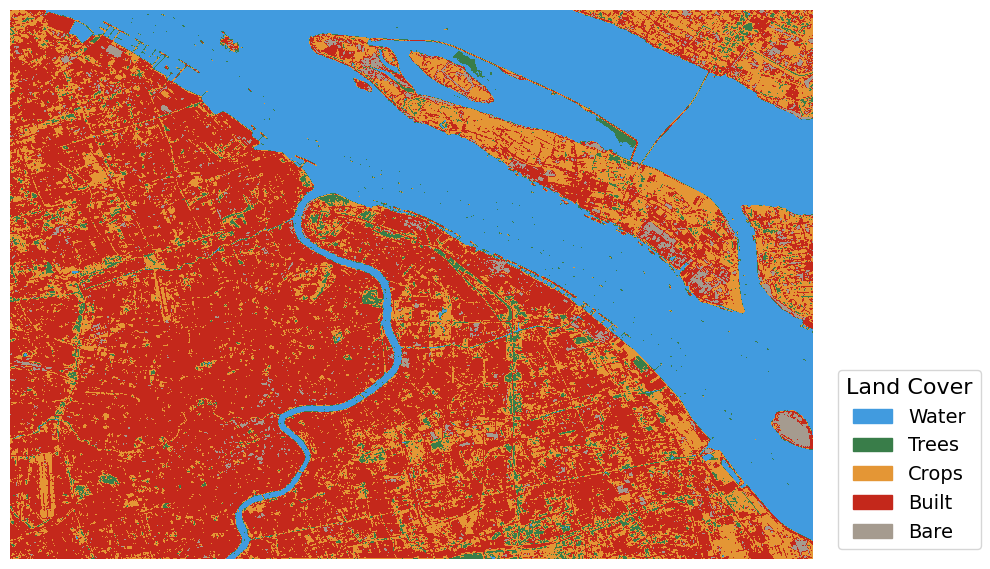

In [8]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# 设置颜色和类别
color_scheme = {
    'Water': '#419BDF',
    'Trees': '#397D49',
    'Crops': '#E49635',
    'Built': '#C4281B',
    'Bare': '#A59B8F'
}
palette = list(color_scheme.values())
classes = list(color_scheme.keys())

# 读取 GeoTIFF
with rasterio.open('shanghaiUniformSamplingMLP.tif') as src:
    image = src.read(1)

# 绘图
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.matplotlib.colors.ListedColormap(palette)
im = ax.imshow(image, cmap=cmap, vmin=0, vmax=4)
ax.axis('off')

# 添加图例，放在图像外部（右下角）
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
ax.legend(
    handles=legend_patches,
    title="Land Cover",
    loc='lower left',
    bbox_to_anchor=(1.02, 0),  # 右下角外侧
    frameon=True,
    fontsize=14,
    title_fontsize=16
)

# 调整布局以适应图例位置
plt.tight_layout()
plt.savefig("Shanghai_MLP_Classification_with_Legend_External.png", dpi=300, bbox_inches='tight')
plt.show()

